In [1]:
%matplotlib widget

In [2]:
import matplotlib as mpl

mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

Plot saved as absorption_length_comparison.png


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


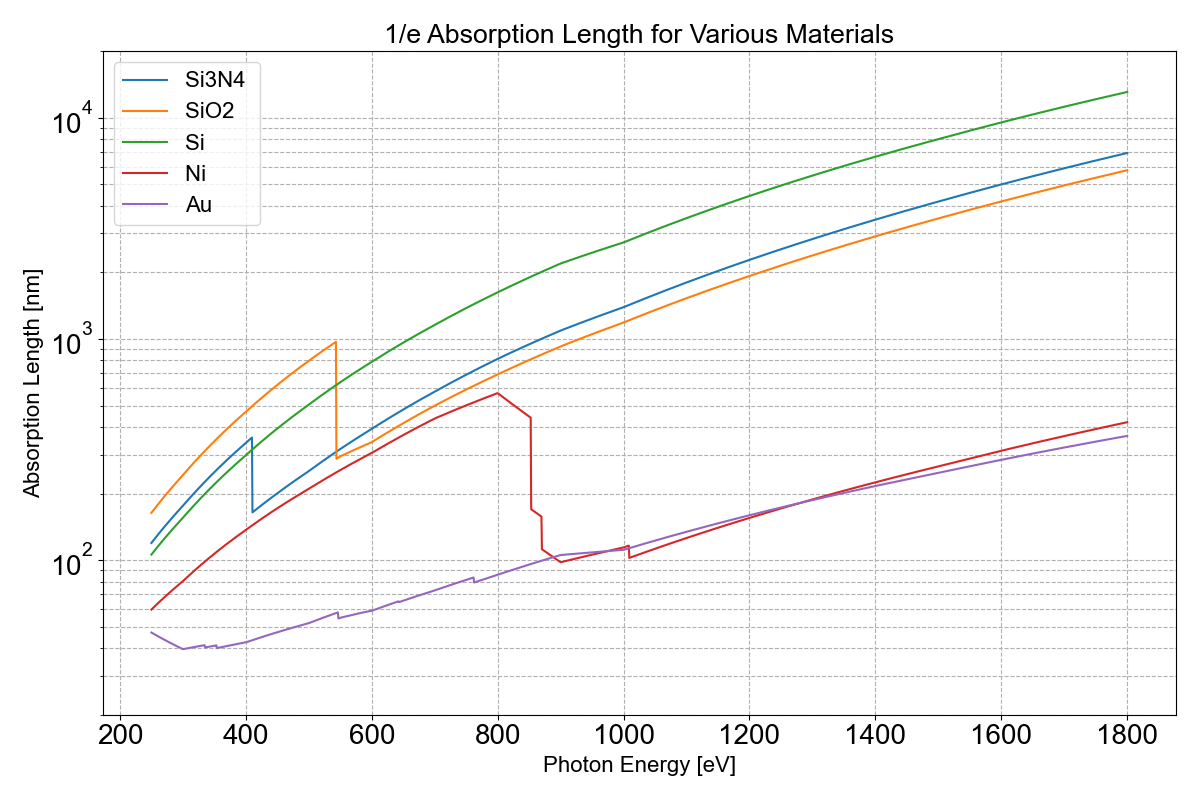

In [3]:
import os
import xraylib
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---

# Define the energy range (250 eV to 1800 eV)
# xraylib functions expect energy in keV
energy_start_kev = 0.25  # 250 eV
energy_end_kev = 1.8     # 1800 eV
num_points = 2000         # Number of points for the plot

# Define the materials to plot
# We'll store them in a dictionary with their type and properties
materials = {
    "Si3N4": {"type": "compound", "density": 3.17},  # Using 3.17 g/cm³
    "SiO2":  {"type": "compound", "density": 2.65},  # Common density for amorphous SiO2
    "Si":    {"type": "element", "Z": 14},
    "Ni":    {"type": "element", "Z": 28},
    "Au":    {"type": "element", "Z": 79},
}

# --- Initialization ---

# Initialize the xraylib library
try:
    xraylib.XRayInit()
except AttributeError:
    # XRayInit is deprecated and auto-initializes in modern versions
    pass

# Get densities for elements from xraylib and add to our dictionary
for material, props in materials.items():
    if props["type"] == "element":
        props["density"] = xraylib.ElementDensity(props["Z"])

# Create an array of energies in keV
energies_kev = np.linspace(energy_start_kev, energy_end_kev, num_points)
# Convert energies from keV to eV for the plot's x-axis
energies_ev = energies_kev * 1000

# --- Plotting Setup ---
plt.figure(figsize=(12, 8))
plt.title("1/e Absorption Length for Various Materials")
plt.xlabel("Photon Energy [eV]")
plt.ylabel("Absorption Length [nm]")
# Use a logarithmic scale for the y-axis, as values span orders of magnitude
plt.yscale('log')
plt.grid(True, which="both", ls="--")

# --- Calculation and Plotting Loop ---

# Loop over each material, calculate its absorption length, and plot it
for material_name, props in materials.items():
    
    mu_mass_cm2_g = np.zeros(num_points)
    density = props["density"]
    
    # Calculate mass absorption coefficient (mu/rho)
    if props["type"] == "compound":
        for i, E_kev in enumerate(energies_kev):
            mu_mass_cm2_g[i] = xraylib.CS_Total_CP(material_name, E_kev)
        # Create a label for the legend
        label = f"{material_name} "
            
    elif props["type"] == "element":
        Z = props["Z"]
        for i, E_kev in enumerate(energies_kev):
            mu_mass_cm2_g[i] = xraylib.CS_Total(Z, E_kev)
        # Create a label for the legend
        label = f"{material_name} "

    # Calculate the linear absorption coefficient (mu = (mu/rho) * rho)
    mu_linear_cm_inv = mu_mass_cm2_g * density

    # Calculate the absorption length (1/e)
    # This is 1 / mu
    with np.errstate(divide='ignore'):
        abs_length_cm = 1.0 / mu_linear_cm_inv

    # Convert absorption length from cm to micrometers (µm)
    # 1 cm = 10,000 µm
    abs_length_nm = abs_length_cm * 1e7

    # Plot the results for this material
    plt.plot(energies_ev, abs_length_nm, label=label)

# --- Finalize Plot ---
plt.ylim([20,2e4])
plt.legend()
plt.tight_layout()

# Save the figure to a fileπ
plt.savefig("absorption_length_comparison.png")
print("Plot saved as absorption_length_comparison.png")
plt.savefig("absorption_length_comparison.eps", format='eps')

# Show the plot
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot saved as pi_phase_Gshift_thickness.png


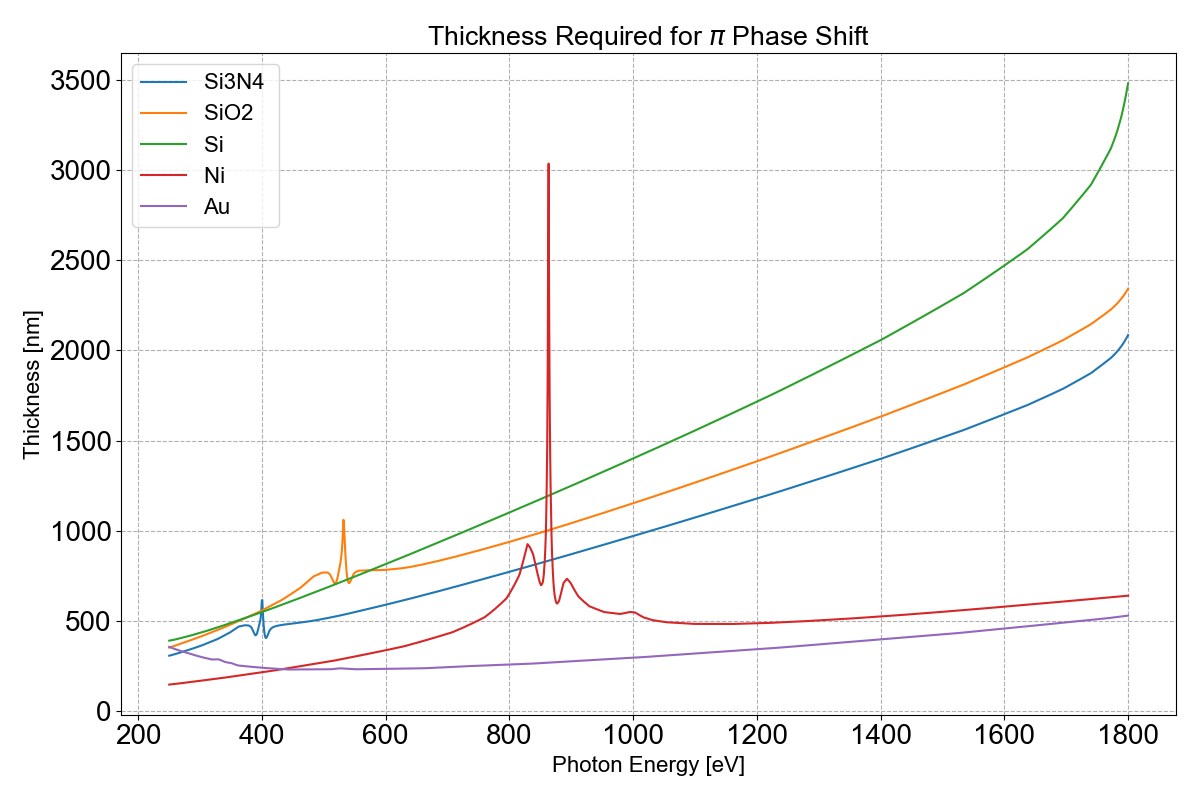

In [4]:
import os
import xraylib
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---

# Define the energy range (250 eV to 1800 eV)
# xraylib functions expect energy in keV
energy_start_kev = 0.25  # 250 eV
energy_end_kev = 1.8     # 1800 eV
num_points = 2000         # Number of points for the plot

# Define the materials to plot
materials = {
    "Si3N4": {"type": "compound", "density": 3.17},  # Using 3.17 g/cm³
    "SiO2":  {"type": "compound", "density": 2.65},  # Amorphous SiO2
    "Si":    {"type": "element", "Z": 14},
    "Ni":    {"type": "element", "Z": 28},
    "Au":    {"type": "element", "Z": 79},
}

# Wavelength-Energy constant
# hc = 12.3984 Angstrom * keV
HC_ANGSTROM_KEV = 12.3984

# --- Initialization ---

# Initialize the xraylib library
try:
    xraylib.XRayInit()
except AttributeError:
    # XRayInit is deprecated and auto-initializes in modern versions
    pass

# Get densities for elements from xraylib
for material, props in materials.items():
    if props["type"] == "element":
        props["density"] = xraylib.ElementDensity(props["Z"])

# Create an array of energies in keV
energies_kev = np.linspace(energy_start_kev, energy_end_kev, num_points)
# Convert energies from keV to eV for the plot's x-axis
energies_ev = energies_kev * 1000

# --- Plotting Setup ---
plt.figure(figsize=(12, 8))
# Use LaTeX for the pi symbol in the title
plt.title(r"Thickness Required for $\pi$ Phase Shift")
plt.xlabel("Photon Energy [eV]")
plt.ylabel("Thickness [nm]")
# Use a logarithmic scale for the y-axis
# plt.yscale('log')
plt.grid(True, which="both", ls="--")

# --- Calculation and Plotting Loop ---

for material_name, props in materials.items():
    
    thickness_nm = np.zeros(num_points)
    density = props["density"]
    
    for i, E_kev in enumerate(energies_kev):
        try:
            # 1. Get delta (decrement of real part of refractive index)
            # xraylib.Refractive_Index_Re returns (1 - delta)
            one_minus_delta = xraylib.Refractive_Index_Re(material_name, E_kev, density)
            delta = 1.0 - one_minus_delta
            
            # 2. Get wavelength in Angstroms
            lambda_angstrom = HC_ANGSTROM_KEV / E_kev
            
            # 3. Calculate thickness for pi-shift (t = lambda / (2 * delta))
            # Result is in Angstroms
            t_angstrom = lambda_angstrom / (2.0 * delta)
            
            # 4. Convert thickness from Angstroms to micrometers
            # 1 micrometer = 10,000 Angstroms
            thickness_nm[i] = t_angstrom * 1e-1
            
        except Exception as e:
            # Handle cases where calculation might fail (e.g., delta is zero)
            thickness_nm[i] = np.nan
            print(f"Error for {material_name} at {E_kev} keV: {e}")

    # Create a label for the legend
    if props["type"] == "compound":
        label = f"{material_name} "
    else:
        label = f"{material_name} "

    # Plot the results for this material
    plt.plot(energies_ev, thickness_nm, label=label)

# --- Finalize Plot ---
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("pi_phase_shift_thickness.png")


print("Plot saved as pi_phase_Gshift_thickness.png")
plt.savefig("pi_phase_shift_thickness.eps", format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Plot saved as transmission_at_pi_shift.png


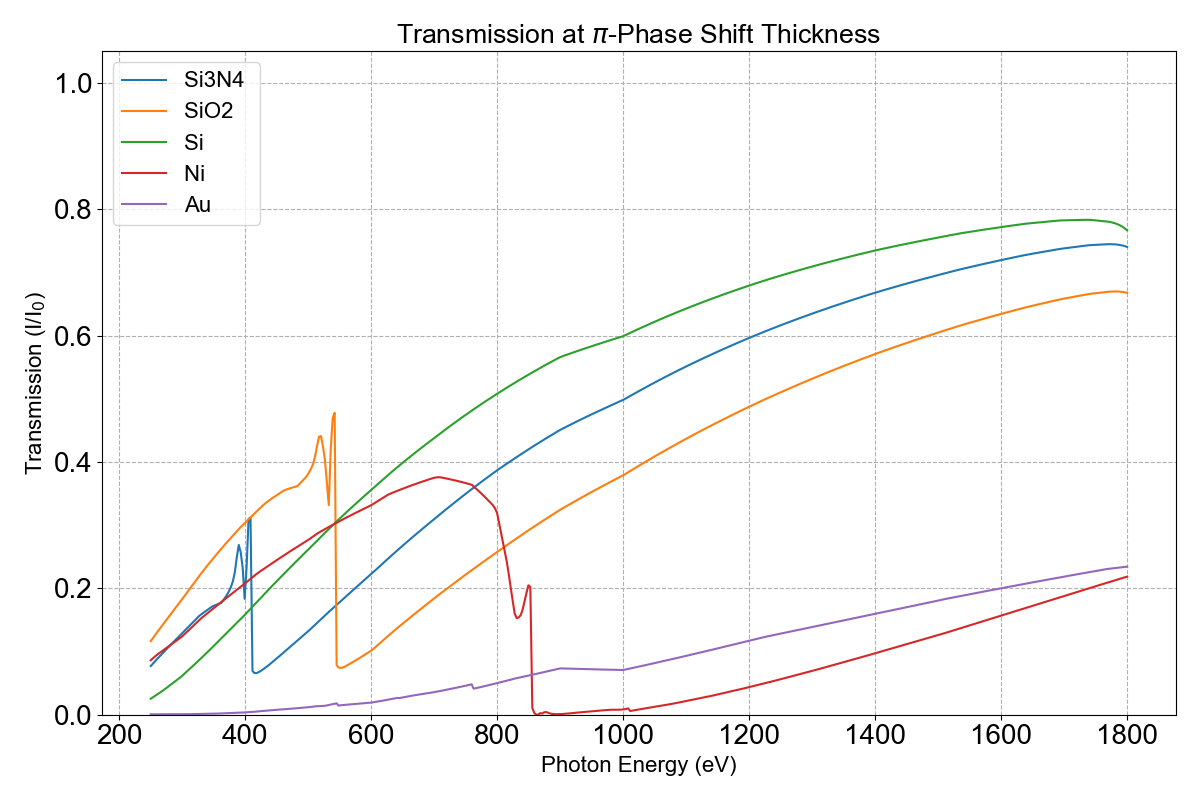

In [5]:
import os
import xraylib
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---

# Define the energy range (250 eV to 1800 eV)
# xraylib functions expect energy in keV
energy_start_kev = 0.25  # 250 eV
energy_end_kev = 1.8     # 1800 eV
num_points = 500         # Number of points for the plot

# Define the materials to plot
materials = {
    "Si3N4": {"type": "compound", "density": 3.17},  # Using 3.17 g/cm³
    "SiO2":  {"type": "compound", "density": 2.65},  # Amorphous SiO2
    "Si":    {"type": "element", "Z": 14},
    "Ni":    {"type": "element", "Z": 28},
    "Au":    {"type": "element", "Z": 79},
}

# Wavelength-Energy constant
# hc = 12.3984 Angstrom * keV
# 1 cm = 1e8 Angstrom
HC_CM_KEV = 12.3984e-8

# --- Initialization ---

# Initialize the xraylib library
try:
    xraylib.XRayInit()
except AttributeError:
    # XRayInit is deprecated and auto-initializes in modern versions
    pass

# Get densities for elements from xraylib
for material, props in materials.items():
    if props["type"] == "element":
        props["density"] = xraylib.ElementDensity(props["Z"])

# Create an array of energies in keV
energies_kev = np.linspace(energy_start_kev, energy_end_kev, num_points)
# Convert energies from keV to eV for the plot's x-axis
energies_ev = energies_kev * 1000

# --- Plotting Setup ---
plt.figure(figsize=(12, 8))
# Use LaTeX for the pi symbol in the title
plt.title(r"Transmission at $\pi$-Phase Shift Thickness")
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Transmission (I/I$_0$)")
# A linear scale is usually best for transmission
plt.yscale('linear')
plt.ylim(0, 1.05) # Set Y-axis from 0 to 1
plt.grid(True, which="both", ls="--")

# --- Calculation and Plotting Loop ---

for material_name, props in materials.items():
    
    transmission = np.zeros(num_points)
    density = props["density"]
    
    for i, E_kev in enumerate(energies_kev):
        try:
            # 1. Get delta (decrement of real part of refractive index)
            # xraylib.Refractive_Index_Re returns (1 - delta)
            one_minus_delta = xraylib.Refractive_Index_Re(material_name, E_kev, density)
            delta = 1.0 - one_minus_delta
            
            # 2. Get wavelength in cm
            lambda_cm = HC_CM_KEV / E_kev
            
            # 3. Calculate thickness for pi-shift (t = lambda / (2 * delta))
            # Result is in cm
            if delta == 0:
                t_pi_cm = np.inf
                transmission[i] = np.nan # Avoid calculation
                continue
                
            t_pi_cm = lambda_cm / (2.0 * delta)
            
            # 4. Get linear absorption coefficient (mu) in cm^-1
            if props["type"] == "compound":
                mu_mass_cm2_g = xraylib.CS_Total_CP(material_name, E_kev)
            else: # element
                mu_mass_cm2_g = xraylib.CS_Total(props["Z"], E_kev)
            
            mu_linear_cm_inv = mu_mass_cm2_g * density

            # 5. Calculate transmission: T = exp(-mu * t)
            transmission[i] = np.exp(-mu_linear_cm_inv * t_pi_cm)
            
        except Exception as e:
            # Handle cases where calculation might fail
            transmission[i] = np.nan
            print(f"Error for {material_name} at {E_kev} keV: {e}")

    # Create a label for the legend
    if props["type"] == "compound":
        label = f"{material_name} "
    else:
        label = f"{material_name} "

    # Plot the results for this material
    plt.plot(energies_ev, transmission, label=label)

# --- Finalize Plot ---
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("transmission_at_pi_shift.png")

print("Plot saved as transmission_at_pi_shift.png")
plt.savefig("transmission_at_pi_shift.eps", format='eps')

In [6]:
import os
import xraylib
import numpy as np

# --- Constants ---
# Wavelength-Energy constant (hc)
# hc = 12.3984 Angstrom * keV
# 1 cm = 1e8 Angstrom
HC_CM_KEV = 12.3984e-8

# --- Library Initialization ---
try:
    xraylib.XRayInit()
except AttributeError:
    # XRayInit is deprecated and auto-initializes in modern versions
    pass

def calculate_grating_performance(
    mat_sub: str, 
    rho_sub: float, 
    t_sub_um: float, 
    mat_grat: str, 
    rho_grat: float, 
    t_grat_um: float, 
    energy_ev: float
) -> dict:
    """
    Calculates the performance of a transmission grating on a substrate.

    Args:
        mat_sub (str): Material string for the substrate (e.g., "Si3N4", "Si").
        rho_sub (float): Density of the substrate in g/cm³.
        t_sub_um (float): Thickness of the substrate in micrometers (µm).
        mat_grat (str): Material string for the grating bars (e.g., "Si", "Au").
        rho_grat (float): Density of the grating bars in g/cm³.
        t_grat_um (float): Thickness of the grating bars in micrometers (µm).
        energy_ev (float): Photon energy in eV.

    Returns:
        dict: A dictionary containing the performance metrics:
              - 'phase_shift_rad' (float): Phase shift (Delta_phi) in radians.
              - 'transmission_sub' (float): Transmission through substrate (T1).
              - 'transmission_grat' (float): Transmission through sub + grating (T2).
              - 'efficiency_1st_order' (float): 1st order diffraction efficiency.
              - 'transmission_avg' (float): Average transmission (T1 + T2) / 2.
    """
    
    try:
        # --- 1. Convert Inputs ---
        energy_kev = energy_ev / 1000.0
        t_sub_cm = t_sub_um * 1e-4
        t_grat_cm = t_grat_um * 1e-4
        wavelength_cm = HC_CM_KEV / energy_kev

        # --- 2. Calculate Properties for Path 1 (Substrate Only) ---
        
        # Get refractive index components (n = 1 - delta + i*beta)
        delta_sub = 1.0 - xraylib.Refractive_Index_Re(mat_sub, energy_kev, rho_sub)
        beta_sub = xraylib.Refractive_Index_Im(mat_sub, energy_kev, rho_sub)
        
        # Phase delay relative to vacuum (phi = 2*pi*delta*t / lambda)
        phi_1 = (2 * np.pi * delta_sub / wavelength_cm) * t_sub_cm
        
        # Transmission (T = exp(-mu*t) = exp(-4*pi*beta*t / lambda))
        T_1 = np.exp(-(4 * np.pi * beta_sub / wavelength_cm) * t_sub_cm)

        # --- 3. Calculate Properties for Grating Layer ---
        
        delta_grat = 1.0 - xraylib.Refractive_Index_Re(mat_grat, energy_kev, rho_grat)
        beta_grat = xraylib.Refractive_Index_Im(mat_grat, energy_kev, rho_grat)

        # Phase delay and Transmission for the grating layer *itself*
        phi_grat_layer = (2 * np.pi * delta_grat / wavelength_cm) * t_grat_cm
        T_grat_layer = np.exp(-(4 * np.pi * beta_grat / wavelength_cm) * t_grat_cm)
        
        # --- 4. Calculate Properties for Path 2 (Substrate + Grating) ---
        
        # Total phase delay is additive
        phi_2 = phi_1 + phi_grat_layer
        
        # Total transmission is multiplicative
        T_2 = T_1 * T_grat_layer

        # --- 5. Calculate Final Metrics ---
        
        # The phase shift *of the grating* is the difference between the two paths
        phase_shift_rad = phi_2 - phi_1  # This simplifies to phi_grat_layer

        # 1st Order Efficiency (eta_1) for a 1:1 binary grating
        # eta_1 = (1/pi^2) * |sqrt(T1) - sqrt(T2)*exp(i*Delta_phi)|^2  (if phi_1=0)
        # More general: eta_1 = (1/pi^2) * |tau_1 - tau_2|^2
        # This expands to:
        term1 = T_1 + T_2
        term2 = 2 * np.sqrt(T_1 * T_2) * np.cos(phase_shift_rad)
        efficiency_1st_order = (1.0 / np.pi**2) * (term1 - term2)

        # Average transmission (total throughput for 1:1 grating)
        transmission_avg = (T_1 + T_2) / 2.0

        return {
            "phase_shift_rad": phase_shift_rad,
            "transmission_sub": T_1,
            "transmission_grat": T_2,
            "efficiency_1st_order": efficiency_1st_order,
            "transmission_avg": transmission_avg
        }

    except Exception as e:
        print(f"Error during calculation at {energy_ev} eV: {e}")
        return {
            "phase_shift_rad": np.nan,
            "transmission_sub": np.nan,
            "transmission_grat": np.nan,
            "efficiency_1st_order": np.nan,
            "transmission_avg": np.nan
        }

# --- Example Usage ---


In [7]:

if __name__ == "__main__":
    
    # --- Example 1: Si Grating on Si3N4 Membrane ---
    
    # Define materials and their properties
    sub_mat = "Si3N4"
    sub_rho = 3.17  # g/cm³ (must be provided)
    sub_t_um = 1    # 100 nm membrane
    
    grat_mat = "SiO2"
    grat_rho = 2.65 # Get density for Si from xraylib
    grat_t_um = 0.77   # 200 nm grating bars
    
    # Define energy
    energy = 500  # eV
    
    print(f"--- Calculating for {grat_mat} on {sub_mat} at {energy} eV ---")
    
    results = calculate_grating_performance(
        sub_mat, sub_rho, sub_t_um,
        grat_mat, grat_rho, grat_t_um,
        energy
    )
    
    if not np.isnan(results["phase_shift_rad"]):
        # Your prompt requested:
        # 1. "efficiency for pi-phase shift" -> We provide the 1st order efficiency
        # 2. "the transmission" -> We provide the average transmission
        
        print(f"  Efficiency (1st Order): {results['efficiency_1st_order'] * 100:.2f} %")
        print(f"  Transmission (Average): {results['transmission_avg'] * 100:.2f} %")
        
        print("\n  --- Detailed Metrics ---")
        print(f"  Phase Shift: {results['phase_shift_rad']:.3f} rad ({results['phase_shift_rad']*180/np.pi:.2f} deg)")
        print(f"  Transmission (Valley): {results['transmission_sub'] * 100:.2f} %")
        print(f"  Transmission (Peak):   {results['transmission_grat'] * 100:.2f} %")


    # --- Example 2: Au Grating on Si Membrane (for contrast) ---
    
    # Define materials and their properties
    sub_mat = "Si"
    sub_rho = xraylib.ElementDensity(14) 
    sub_t_um = 1    # 500 nm membrane
    
    grat_mat = "Ni"
    grat_rho = xraylib.ElementDensity(28) # Get density for Au from xraylib
    grat_t_um = 0.27  # 100 nm grating bars
    
    energy = 500  # eV
    
    print(f"\n--- Calculating for {grat_mat} on {sub_mat} at {energy} eV ---")
    
    results = calculate_grating_performance(
        sub_mat, sub_rho, sub_t_um,
        grat_mat, grat_rho, grat_t_um,
        energy
    )
    
    if not np.isnan(results["phase_shift_rad"]):
        print(f"  Efficiency (1st Order): {results['efficiency_1st_order'] * 100:.2f} %")
        print(f"  Transmission (Average): {results['transmission_avg'] * 100:.2f} %")
        print(f"  Phase Shift: {results['phase_shift_rad']:.3f} rad ({results['phase_shift_rad']*180/np.pi:.2f} deg)")

--- Calculating for SiO2 on Si3N4 at 500 eV ---
  Efficiency (1st Order): 0.50 %
  Transmission (Average): 1.32 %

  --- Detailed Metrics ---
  Phase Shift: 3.151 rad (180.53 deg)
  Transmission (Valley): 1.91 %
  Transmission (Peak):   0.73 %

--- Calculating for Ni on Si at 500 eV ---
  Efficiency (1st Order): 3.25 %
  Transmission (Average): 8.80 %
  Phase Shift: 3.143 rad (180.07 deg)


In [8]:
 # Define materials and their properties
sub_mat = "Si"
sub_rho =  xraylib.ElementDensity(14) # g/cm³ (must be provided)
sub_t_um = 0.32    # 100 nm membrane
    
grat_mat = "Si"
grat_rho = xraylib.ElementDensity(14) # Get density for Si from xraylib
grat_t_um = 0.68   # 200 nm grating bars
    
# Define energy
energy = 500  # eV
    
print(f"--- Calculating for {grat_mat} on {sub_mat} at {energy} eV ---")
    
results = calculate_grating_performance(
    sub_mat, sub_rho, sub_t_um,
    grat_mat, grat_rho, grat_t_um,
    energy
)
    
if not np.isnan(results["phase_shift_rad"]):
    # Your prompt requested:
    # 1. "efficiency for pi-phase shift" -> We provide the 1st order efficiency
    # 2. "the transmission" -> We provide the average transmission
    
    print(f"  Efficiency (1st Order): {results['efficiency_1st_order'] * 100:.2f} %")
    print(f"  Transmission (Average): {results['transmission_avg'] * 100:.2f} %")
        
    print("\n  --- Detailed Metrics ---")
    print(f"  Phase Shift: {results['phase_shift_rad']:.3f} rad ({results['phase_shift_rad']*180/np.pi:.2f} deg)")
    print(f"  Transmission (Valley): {results['transmission_sub'] * 100:.2f} %")
    print(f"  Transmission (Peak):   {results['transmission_grat'] * 100:.2f} %")

--- Calculating for Si on Si at 500 eV ---
  Efficiency (1st Order): 12.26 %
  Transmission (Average): 33.42 %

  --- Detailed Metrics ---
  Phase Shift: 3.151 rad (180.56 deg)
  Transmission (Valley): 53.05 %
  Transmission (Peak):   13.80 %


In [9]:
 # Define materials and their properties
sub_mat = "Si"
sub_rho =  xraylib.ElementDensity(14) # g/cm³ (must be provided)
sub_t_um = 0.32    # 100 nm membrane
    
grat_mat = "Si"
grat_rho = xraylib.ElementDensity(14) # Get density for Si from xraylib
grat_t_um = 0.68   # 200 nm grating bars
    
# Define energy
energy = 500  # eV
    
print(f"--- Calculating for {grat_mat} on {sub_mat} at {energy} eV ---")
    
results = calculate_grating_performance(
    sub_mat, sub_rho, sub_t_um,
    grat_mat, grat_rho, grat_t_um,
    energy
)
    
if not np.isnan(results["phase_shift_rad"]):
    # Your prompt requested:
    # 1. "efficiency for pi-phase shift" -> We provide the 1st order efficiency
    # 2. "the transmission" -> We provide the average transmission
    
    print(f"  Efficiency (1st Order): {results['efficiency_1st_order'] * 100:.2f} %")
    print(f"  Transmission (Average): {results['transmission_avg'] * 100:.2f} %")
        
    print("\n  --- Detailed Metrics ---")
    print(f"  Phase Shift: {results['phase_shift_rad']:.3f} rad ({results['phase_shift_rad']*180/np.pi:.2f} deg)")
    print(f"  Transmission (Valley): {results['transmission_sub'] * 100:.2f} %")
    print(f"  Transmission (Peak):   {results['transmission_grat'] * 100:.2f} %")

--- Calculating for Si on Si at 500 eV ---
  Efficiency (1st Order): 12.26 %
  Transmission (Average): 33.42 %

  --- Detailed Metrics ---
  Phase Shift: 3.151 rad (180.56 deg)
  Transmission (Valley): 53.05 %
  Transmission (Peak):   13.80 %


In [22]:
import os
import xraylib
import numpy as np

# --- Constants ---
# Wavelength-Energy constant (hc)
# hc = 12.3984 Angstrom * keV
# 1 cm = 1e8 Angstrom
HC_CM_KEV = 12.3984e-8

# --- Library Initialization ---
try:
    xraylib.XRayInit()
except AttributeError:
    # XRayInit is deprecated and auto-initializes in modern versions
    pass

def calculate_grating_performance(
    mat_sub: str, 
    rho_sub: float, 
    t_sub_um: float, 
    mat_grat: str, 
    rho_grat: float, 
    t_grat_um: float, 
    energy_ev: float
) -> dict:
    """
    Calculates the performance of a transmission grating on a substrate.

    Args:
        mat_sub (str): Material string for the substrate (e.g., "Si3N4", "Si").
        rho_sub (float): Density of the substrate in g/cm³.
        t_sub_um (float): Thickness of the substrate in micrometers (µm).
        mat_grat (str): Material string for the grating bars (e.g., "Si", "Au").
        rho_grat (float): Density of the grating bars in g/cm³.
        t_grat_um (float): Thickness of the grating bars in micrometers (µm).
        energy_ev (float): Photon energy in eV.

    Returns:
        dict: A dictionary containing the performance metrics:
              - 'phase_shift_rad' (float): Phase shift (Delta_phi) in radians.
              - 'transmission_sub' (float): Transmission through substrate (T1).
              - 'transmission_grat' (float): Transmission through sub + grating (T2).
              - 'efficiency_1st_order' (float): 1st order diffraction efficiency.
              - 'transmission_avg' (float): Average transmission (T1 + T2) / 2.
    """
    
    try:
        # --- 1. Convert Inputs ---
        energy_kev = energy_ev / 1000.0
        t_sub_cm = t_sub_um * 1e-4
        t_grat_cm = t_grat_um * 1e-4
        wavelength_cm = HC_CM_KEV / energy_kev

        # --- 2. Calculate Properties for Path 1 (Substrate Only) ---
        
        # Get refractive index components (n = 1 - delta + i*beta)
        delta_sub = 1.0 - xraylib.Refractive_Index_Re(mat_sub, energy_kev, rho_sub)
        beta_sub = xraylib.Refractive_Index_Im(mat_sub, energy_kev, rho_sub)
        
        # Phase delay relative to vacuum (phi = 2*pi*delta*t / lambda)
        phi_1 = (2 * np.pi * delta_sub / wavelength_cm) * t_sub_cm
        
        # Transmission (T = exp(-mu*t) = exp(-4*pi*beta*t / lambda))
        T_1 = np.exp(-(4 * np.pi * beta_sub / wavelength_cm) * t_sub_cm)

        # --- 3. Calculate Properties for Grating Layer ---
        
        delta_grat = 1.0 - xraylib.Refractive_Index_Re(mat_grat, energy_kev, rho_grat)
        beta_grat = xraylib.Refractive_Index_Im(mat_grat, energy_kev, rho_grat)

        # Phase delay and Transmission for the grating layer *itself*
        phi_grat_layer = (2 * np.pi * delta_grat / wavelength_cm) * t_grat_cm
        T_grat_layer = np.exp(-(4 * np.pi * beta_grat / wavelength_cm) * t_grat_cm)
        
        # --- 4. Calculate Properties for Path 2 (Substrate + Grating) ---
        
        # Total phase delay is additive
        phi_2 = phi_1 + phi_grat_layer
        
        # Total transmission is multiplicative
        T_2 = T_1 * T_grat_layer

        # --- 5. Calculate Final Metrics ---
        
        # The phase shift *of the grating* is the difference between the two paths
        phase_shift_rad = phi_2 - phi_1  # This simplifies to phi_grat_layer

        # 1st Order Efficiency (eta_1) for a 1:1 binary grating
        # eta_1 = (1/pi^2) * [ (sqrt(T1) - sqrt(T2))^2 + 4*sqrt(T1*T2) * sin^2(Delta_phi/2) ]
        
        # Amplitude contrast term
        amplitude_term = (np.sqrt(T_1) - np.sqrt(T_2))**2
        
        # Phase contrast term
        phase_term = 4.0 * np.sqrt(T_1 * T_2) * (np.sin(phase_shift_rad / 2.0))**2
        
        # Total 1st order efficiency
        efficiency_1st_order = (1.0 / np.pi**2) * (amplitude_term + phase_term)

        # Average transmission (total throughput for 1:1 grating)
        transmission_avg = (T_1 + T_2) / 2.0

        return {
            "phase_shift_rad": phase_shift_rad,
            "transmission_sub": T_1,
            "transmission_grat": T_2,
            "efficiency_1st_order": efficiency_1st_order,
            "transmission_avg": transmission_avg
        }

    except Exception as e:
        print(f"Error during calculation at {energy_ev} eV: {e}")
        return {
            "phase_shift_rad": np.nan,
            "transmission_sub": np.nan,
            "transmission_grat": np.nan,
            "efficiency_1st_order": np.nan,
            "transmission_avg": np.nan
        }

# --- Example Usage ---

if __name__ == "__main__":
    
    # --- Example 1: Si Grating on Si3N4 Membrane ---
    
    # Define materials and their properties
    sub_mat = "Si"
    sub_rho = xraylib.ElementDensity(14)  # g/cm³ (must be provided)
    sub_t_um = 0.483    # 100 nm membrane
    
    grat_mat = "Si"
    grat_rho = xraylib.ElementDensity(14) # Get density for Si from xraylib
    grat_t_um = 0.517   # 200 nm grating bars
    
    # Define energy
    energy = 500  # eV
    
    print(f"--- Calculating for {grat_mat} on {sub_mat} at {energy} eV ---")
    
    results = calculate_grating_performance(
        sub_mat, sub_rho, sub_t_um,
        grat_mat, grat_rho, grat_t_um,
        energy
    )
    
    if not np.isnan(results["phase_shift_rad"]):
        print(f"  Efficiency (1st Order): {results['efficiency_1st_order'] * 100:.2f} %")
        print(f"  Transmission (Average): {results['transmission_avg'] * 100:.2f} %")
        
        print("\n  --- Detailed Metrics ---")
        # --- FIX WAS HERE ---
        print(f"  Phase Shift: {results['phase_shift_rad']:.3f} rad ({(results['phase_shift_rad']*180/np.pi):.2f} deg)")
        print(f"  Transmission (Valley): {results['transmission_sub'] * 100:.2f} %")
        print(f"  Transmission (Peak):   {results['transmission_grat'] * 100:.2f} %")


    # --- Example 2: Au Grating on Si Membrane (for contrast) ---
    
    # Define materials and their properties
    sub_mat = "Si"
    sub_rho = xraylib.ElementDensity(14) 
    sub_t_um = 0.5    # 500 nm membrane
    
    grat_mat = "Au"
    grat_rho = xraylib.ElementDensity(79) # Get density for Au from xraylib
    grat_t_um = 0.1   # 100 nm grating bars
    
    energy = 800  # eV
    
    print(f"\n--- Calculating for {grat_mat} on {sub_mat} at {energy} eV ---")
    
    results = calculate_grating_performance(
        sub_mat, sub_rho, sub_t_um,
        grat_mat, grat_rho, grat_t_um,
        energy
    )
    
    if not np.isnan(results["phase_shift_rad"]):
        print(f"  Efficiency (1st Order): {results['efficiency_1st_order'] * 100:.2f} %")
        print(f"  Transmission (Average): {results['transmission_avg'] * 100:.2f} %")
        # --- FIX WAS HERE ---
        print(f"  Phase Shift: {results['phase_shift_rad']:.3f} rad ({(results['phase_shift_rad']*180/np.pi):.2f} deg)")

--- Calculating for Si on Si at 500 eV ---
  Efficiency (1st Order): 8.72 %
  Transmission (Average): 26.11 %

  --- Detailed Metrics ---
  Phase Shift: 2.396 rad (137.28 deg)
  Transmission (Valley): 38.41 %
  Transmission (Peak):   13.80 %

--- Calculating for Au on Si at 800 eV ---
  Efficiency (1st Order): 6.92 %
  Transmission (Average): 48.23 %
  Phase Shift: 1.221 rad (69.95 deg)


In [19]:
mat_sub = "Si"
rho_sub = xraylib.ElementDensity(14)  # g/cm³ (must be provided)
sub_t_um = 0.32    # 100 nm membrane
energy_kev = 0.5
wavelength_cm = HC_CM_KEV / energy_kev *1e7

print(str(1-xraylib.Refractive_Index_Re(mat_sub, energy_kev, rho_sub)) + "_" + str(xraylib.Refractive_Index_Im(mat_sub, energy_kev, rho_sub)))



0.0018289977250151024_0.0003908660831356537
